<a href="https://colab.research.google.com/github/wint3rx3/flowers_classification/blob/main/yohan_week8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 필요한 라이브러리 설치

In [ ]:
pip install tensorflow tensorflow-hub

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

2. 데이터셋 다운로드 준비



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d imsparsh/flowers-dataset

import zipfile

zip_path = "flowers-dataset.zip"  # 다운로드된 파일 이름
extract_path = "./flowers-dataset"  # 압축을 풀 경로

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

TRAIN_DIR = '/content/flowers-dataset/train'
TEST_DIR  = '/content/flowers-dataset/test'

classes = sorted(os.listdir(TRAIN_DIR))
print(classes)

Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


3. EDA

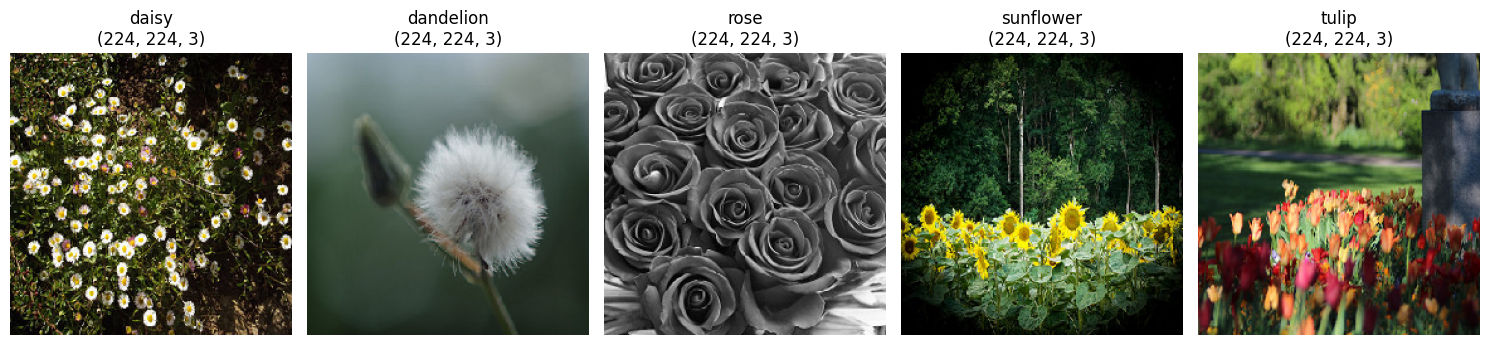

In [ ]:
# 각 클래스별 이미지 시각화 및 사이즈 확인
plt.figure(figsize=(15, 4))
for i, class_name in enumerate(classes):
    class_path = os.path.join(TRAIN_DIR, class_name)
    # 해당 클래스 폴더에서 첫 번째 이미지 선택
    image_files = os.listdir(class_path)
    first_image_path = os.path.join(class_path, image_files[0])
    img = load_img(first_image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{class_name}\n{img_array.shape}")
    plt.axis('off')
plt.tight_layout()
plt.show()

daisy: 501 images
dandelion: 646 images
rose: 497 images
sunflower: 495 images
tulip: 607 images


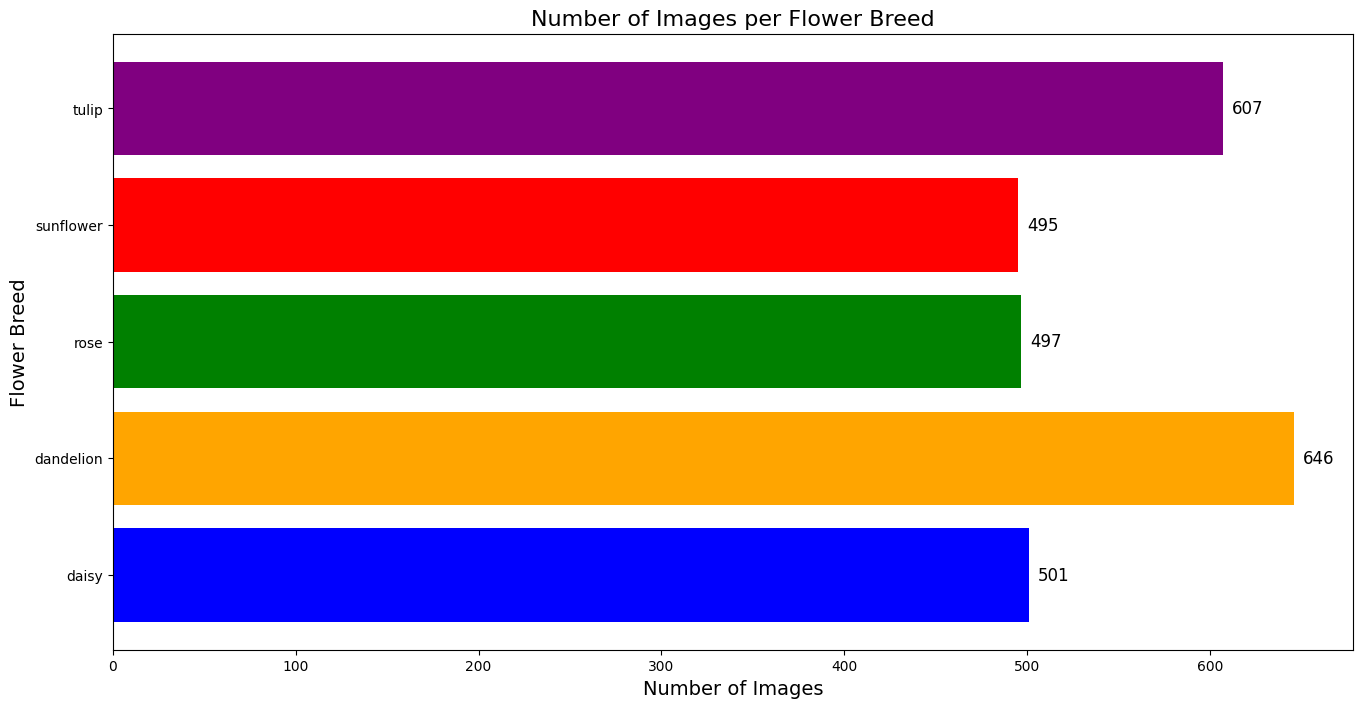

In [ ]:
# 각 클래스별 이미지 갯수 확인
counts = []
for class_name in classes:
    class_path = os.path.join(TRAIN_DIR, class_name)
    count = len(os.listdir(class_path))
    counts.append(count)
    print(f"{class_name}: {count} images")

# 바 그래프 시각화 (영어 라벨, 각 막대 위에 수치 표시)
plt.figure(figsize=(16, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple']

bars = plt.barh(classes, counts, color=colors)

plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Flower Breed', fontsize=14)
plt.title('Number of Images per Flower Breed', fontsize=16)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, int(width),
             va='center', ha='left', fontsize=12)

plt.show()

4, VGG16을 사용한 모델 학습 및 평가

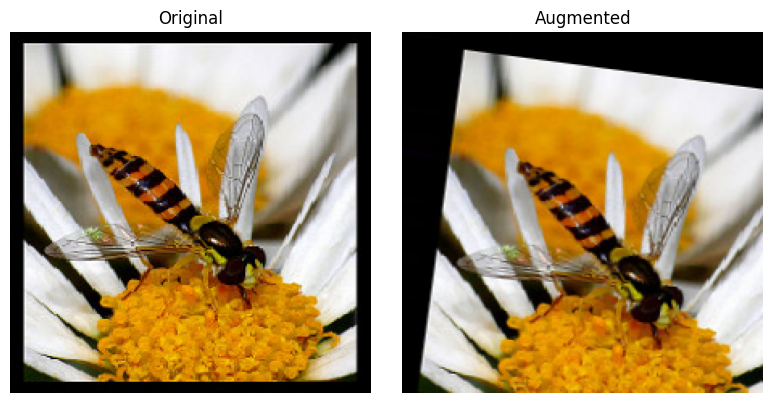

In [ ]:
aug_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

sample_class = classes[0]
sample_class_path = os.path.join(TRAIN_DIR, sample_class)
sample_image_name = os.listdir(sample_class_path)[0]
sample_image_path = os.path.join(sample_class_path, sample_image_name)
sample_img = load_img(sample_image_path, target_size=(224, 224))
sample_img_array = img_to_array(sample_img)

augmented_img_array = aug_gen.random_transform(sample_img_array)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(augmented_img_array.astype('uint8'))
plt.title("Augmented")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
NUM_CLASSES = 5
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False  # 사전 학습된 가중치는 고정

model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 5

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20%를 validation으로 분리
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # 정수형 라벨 사용
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

# 모델 평가 (validation 데이터로 평가)
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3601 - loss: 4.1156 - val_accuracy: 0.6387 - val_loss: 0.9516
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6802 - loss: 0.8676 - val_accuracy: 0.7318 - val_loss: 0.7456
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7740 - loss: 0.6150 - val_accuracy: 0.7664 - val_loss: 0.6681
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7963 - loss: 0.5766 - val_accuracy: 0.7847 - val_loss: 0.6011
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8434 - loss: 0.4626 - val_accuracy: 0.7810 - val_loss: 0.6030
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7984 - loss: 0.5751
Validation Loss: 0.5933
Validation Accuracy: 0.7828


9. 학습 결과 (정확도와 손실) 시각화

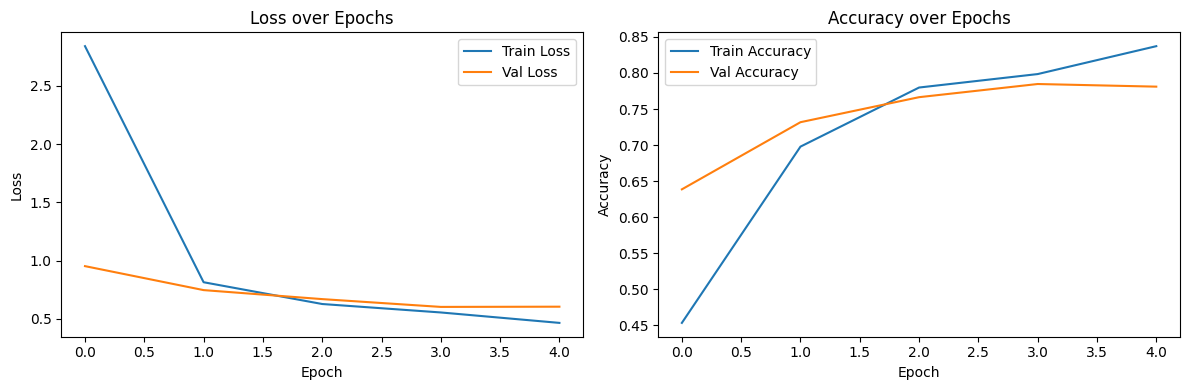

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 나. ResNet

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,279,365 (187.99 MB)

 Trainable params: 25,691,653 (98.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 900ms/step - accuracy: 0.2143 - loss: 16.9926 - val_accuracy: 0.2190 - val_loss: 4.5748
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - accuracy: 0.2863 - loss: 3.4615 - val_accuracy: 0.3449 - val_loss: 1.7915
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - accuracy: 0.4226 - loss: 1.5311 - val_accuracy: 0.4270 - val_loss: 1.4555
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - accuracy: 0.4792 - loss: 1.3354 - val_accuracy: 0.4434 - val_loss: 1.3724
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - accuracy: 0.5063 - loss: 1.2347 - val_accuracy: 0.3942 - val_loss: 1.6029
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.4537 - loss: 1.4960
ResNet Validation Loss: 1.6029
ResNet Validation Accuracy: 0.3942


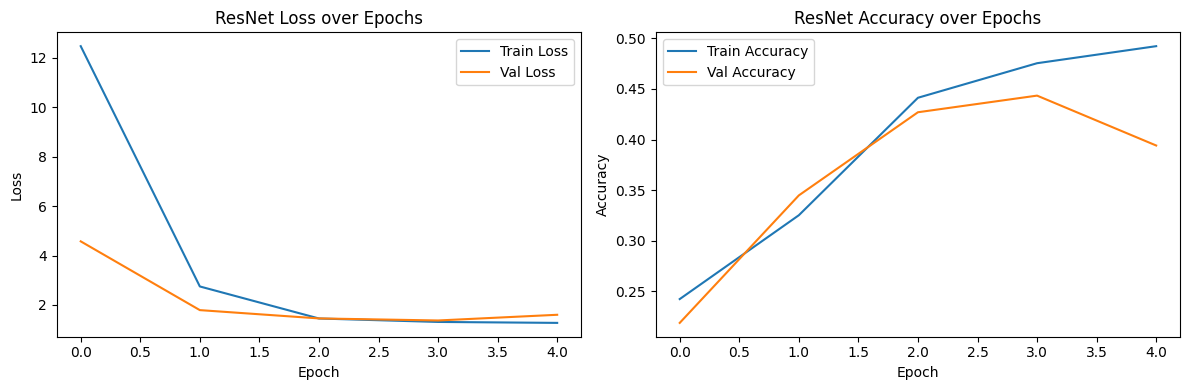

In [ ]:
# ResNet50 베이스 모델 불러오기
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

# 새로운 모델 구성: ResNet50 베이스 + Flatten + Dense 레이어
model_resnet = Sequential([
    resnet_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# 모델 컴파일
model_resnet.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

# ResNet 모델 학습
history_resnet = model_resnet.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data=validation_generator
)

# 모델 평가 (validation 데이터로 평가)
loss_resnet, accuracy_resnet = model_resnet.evaluate(validation_generator)
print(f"ResNet Validation Loss: {loss_resnet:.4f}")
print(f"ResNet Validation Accuracy: {accuracy_resnet:.4f}")

# 학습 결과 시각화: Loss와 Accuracy 추이
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,279,365 (187.99 MB)

 Trainable params: 31,212,037 (119.06 MB)

 Non-trainable params: 18,067,328 (68.92 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2275 - loss: 2.0743
Epoch 1: val_loss improved from inf to 2.08431, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.2284 - loss: 2.0683 - val_accuracy: 0.2354 - val_loss: 2.0843 - learning_rate: 1.0000e-06
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2624 - loss: 1.8400
Epoch 2: val_loss improved from 2.08431 to 1.99209, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2628 - loss: 1.8391 - val_accuracy: 0.2372 - val_loss: 1.9921 - learning_rate: 1.0000e-06
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3284 - loss: 1.7035
Epoch 3: val_loss improved from 1.99209 to 1.92585, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3288 - loss: 1.7028 - val_accuracy: 0.2391 - val_loss: 1.9259 - learning_rate: 1.0000e-06
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3464 - loss: 1.6087
Epoch 4: val_loss improved from 1.92585 to 1.86280, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3468 - loss: 1.6097 - val_accuracy: 0.2518 - val_loss: 1.8628 - learning_rate: 1.0000e-06
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3629 - loss: 1.5985
Epoch 5: val_loss improved from 1.86280 to 1.83385, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3632 - loss: 1.5977 - val_accuracy: 0.2500 - val_loss: 1.8339 - learning_rate: 1.0000e-06
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3846 - loss: 1.5440
Epoch 6: val_loss improved from 1.83385 to 1.79461, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3845 - loss: 1.5446 - val_accuracy: 0.2628 - val_loss: 1.7946 - learning_rate: 1.0000e-06
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3772 - loss: 1.5437
Epoch 7: val_loss improved from 1.79461 to 1.73447, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3779 - loss: 1.5427 - val_accuracy: 0.2719 - val_loss: 1.7345 - learning_rate: 1.0000e-06
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4197 - loss: 1.4827
Epoch 8: val_loss improved from 1.73447 to 1.67635, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4195 - loss: 1.4829 - val_accuracy: 0.2901 - val_loss: 1.6764 - learning_rate: 1.0000e-06
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4276 - loss: 1.4621
Epoch 9: val_loss improved from 1.67635 to 1.66959, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4268 - loss: 1.4629 - val_accuracy: 0.2901 - val_loss: 1.6696 - learning_rate: 1.0000e-06
Epoch 10/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4156 - loss: 1.4773
Epoch 10: val_loss improved from 1.66959 to 1.62319, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4158 - loss: 1.4766 - val_accuracy: 0.3047 - val_loss: 1.6232 - learning_rate: 1.0000e-06
Epoch 11/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4128 - loss: 1.4538
Epoch 11: val_loss did not improve from 1.62319
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4133 - loss: 1.4529 - val_accuracy: 0.3066 - val_loss: 1.6237 - learning_rate: 1.0000e-06
Epoch 12/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4332 - loss: 1.4191
Epoch 12: val_loss improved from 1.62319 to 1.59756, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4336 - loss: 1.4187 - val_accuracy: 0.3303 - val_loss: 1.5976 - learning_rate: 1.0000e-06
Epoch 13/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4419 - loss: 1.4099
Epoch 13: val_loss improved from 1.59756 to 1.57495, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4416 - loss: 1.4106 - val_accuracy: 0.3613 - val_loss: 1.5750 - learning_rate: 1.0000e-06
Epoch 14/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4581 - loss: 1.4008
Epoch 14: val_loss improved from 1.57495 to 1.55616, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4585 - loss: 1.4004 - val_accuracy: 0.3595 - val_loss: 1.5562 - learning_rate: 1.0000e-06
Epoch 15/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4552 - loss: 1.3887
Epoch 15: val_loss improved from 1.55616 to 1.54944, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4553 - loss: 1.3886 - val_accuracy: 0.3485 - val_loss: 1.5494 - learning_rate: 1.0000e-06
Epoch 16/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4795 - loss: 1.3462
Epoch 16: val_loss improved from 1.54944 to 1.50543, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4792 - loss: 1.3468 - val_accuracy: 0.3850 - val_loss: 1.5054 - learning_rate: 1.0000e-06
Epoch 17/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4775 - loss: 1.3611
Epoch 17: val_loss improved from 1.50543 to 1.48875, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4770 - loss: 1.3617 - val_accuracy: 0.3942 - val_loss: 1.4887 - learning_rate: 1.0000e-06
Epoch 18/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4724 - loss: 1.3629
Epoch 18: val_loss improved from 1.48875 to 1.42629, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4723 - loss: 1.3632 - val_accuracy: 0.4307 - val_loss: 1.4263 - learning_rate: 1.0000e-06
Epoch 19/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4803 - loss: 1.3139
Epoch 19: val_loss did not improve from 1.42629
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4798 - loss: 1.3155 - val_accuracy: 0.4307 - val_loss: 1.4602 - learning_rate: 1.0000e-06
Epoch 20/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4806 - loss: 1.3461
Epoch 20: val_loss did not improve from 1.42629
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4801 - loss: 1.3458 - val_accuracy: 0.4106 - val_loss: 1.4507 - learning_rate: 1.0000e-06
Epoch 21/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4909 - loss: 1.3184
Epoch 21: val_loss improved from 1.42629 to 1.39902, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4908 - loss: 1.3188 - val_accuracy: 0.4526 - val_loss: 1.3990 - learning_rate: 1.0000e-06
Epoch 22/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4628 - loss: 1.3530
Epoch 22: val_loss did not improve from 1.39902
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4640 - loss: 1.3521 - val_accuracy: 0.4580 - val_loss: 1.4135 - learning_rate: 1.0000e-06
Epoch 23/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4865 - loss: 1.3096
Epoch 23: val_loss improved from 1.39902 to 1.38129, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4864 - loss: 1.3099 - val_accuracy: 0.4599 - val_loss: 1.3813 - learning_rate: 1.0000e-06
Epoch 24/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4545 - loss: 1.3541
Epoch 24: val_loss did not improve from 1.38129
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4560 - loss: 1.3528 - val_accuracy: 0.4672 - val_loss: 1.3935 - learning_rate: 1.0000e-06
Epoch 25/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5300 - loss: 1.2731
Epoch 25: val_loss improved from 1.38129 to 1.35462, saving model to resnet_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5286 - loss: 1.2748 - val_accuracy: 0.5055 - val_loss: 1.3546 - learning_rate: 1.0000e-06
Epoch 26/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4861 - loss: 1.3172
Epoch 26: val_loss did not improve from 1.35462
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4863 - loss: 1.3166 - val_accuracy: 0.4562 - val_loss: 1.3710 - learning_rate: 1.0000e-06
Epoch 27/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4934 - loss: 1.2856
Epoch 27: val_loss did not improve from 1.35462
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4936 - loss: 1.2858 - val_accuracy: 0.4964 - val_loss: 1.3659 - learning_rate: 1.0000e-06
Epoch 28/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4993 - loss: 1.2989
Epoch 28: val_loss did not improve from 1.35462

Epoch 28: ReduceLROnPlateau reducing learning rate to 1.9999999949504855e-07.
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4998 - loss: 1.2984 - val_accuracy: 0.4891 

18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5067 - loss: 1.2977 - val_accuracy: 0.4763 - val_loss: 1.3454 - learning_rate: 2.0000e-07
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5227 - loss: 1.3082
Fine-Tuned ResNet Validation Loss: 1.3396
Fine-Tuned ResNet Validation Accuracy: 0.4964


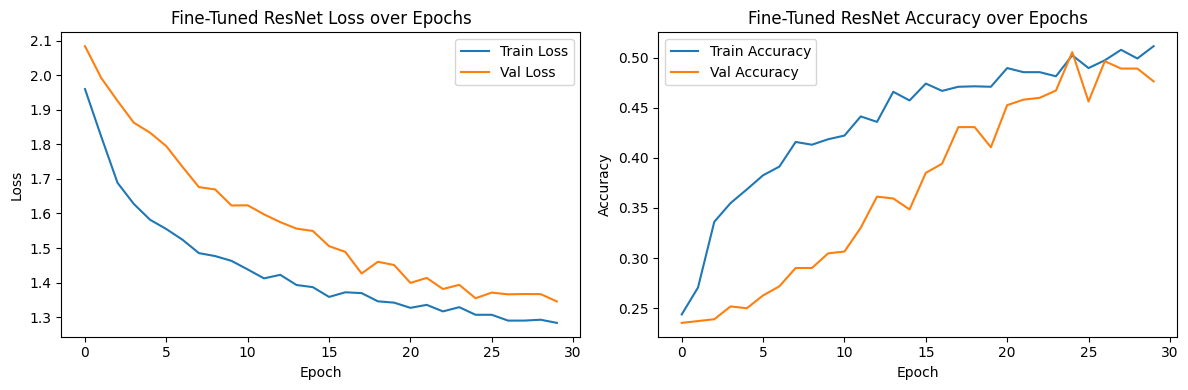

In [ ]:
from tensorflow.keras.applications import ResNet50
from typing_extensions import TypeVarTuple
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

NUM_CLASSES = 5

# ResNet50 베이스 모델 구성
resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in resnet_base.layers:
    layer.trainable = False

for layer in resnet_base.layers[-15:]:
    layer.trainable = True

# 모델 아키텍처 정의
model_resnet_ft = Sequential([
    resnet_base,
    Flatten(),
    Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)  # L2 정규화
    ),
    Dropout(0.3),  # 30% 드롭아웃
    Dense(NUM_CLASSES, activation='softmax')
])

# 모델 컴파일
model_resnet_ft.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet_ft.summary()

# 콜백(Callbacks) 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=TypeVarTuple
)

model_ckpt = ModelCheckpoint(
    'resnet_best.h5',        # 저장될 파일명
    monitor='val_loss',
    save_best_only=True,     # val_loss가 갱신될 때만 저장
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,              # LR을 0.2배로 줄임
    patience=3,              # 3에포크 연속 개선 없으면 LR 감소
    verbose=1
)

callbacks = [early_stop, model_ckpt, reduce_lr]

# 모델 학습
history_resnet_ft = model_resnet_ft.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks
)

#  모델 평가
loss_resnet_ft, accuracy_resnet_ft = model_resnet_ft.evaluate(validation_generator)
print(f"Fine-Tuned ResNet Validation Loss: {loss_resnet_ft:.4f}")
print(f"Fine-Tuned ResNet Validation Accuracy: {accuracy_resnet_ft:.4f}")

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_ft.history['loss'], label='Train Loss')
plt.plot(history_resnet_ft.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-Tuned ResNet Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet_ft.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Fine-Tuned ResNet Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,107,432 (76.70 MB)

 Trainable params: 16,057,861 (61.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.2074 - loss: 20.6116 - val_accuracy: 0.2208 - val_loss: 3.0145
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2093 - loss: 2.4835 - val_accuracy: 0.2354 - val_loss: 1.6093
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2288 - loss: 1.6301 - val_accuracy: 0.2354 - val_loss: 1.6090
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2460 - loss: 1.6089 - val_accuracy: 0.2354 - val_loss: 1.6087
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2342 - loss: 1.6086 - val_accuracy: 0.2354 - val_loss: 1.6084
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.2081 - loss: 5.0689 - val_accuracy: 0.2354 - val_loss: 1.6083
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2054 - loss: 1.6151 - val_accuracy: 0.2354 - val_loss: 1.6083
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2346 - loss: 1.6097 - val_accuracy: 0.2354 - val_loss: 1.6

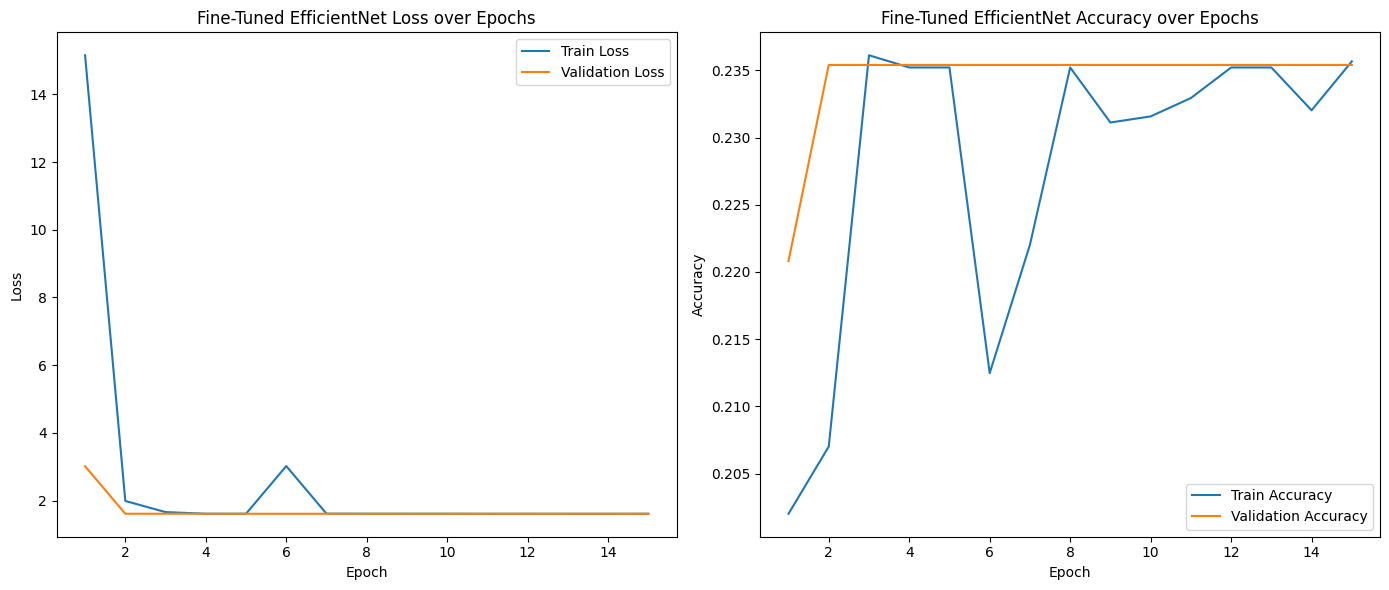

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Build model
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_base.trainable = False

model_efficientnet = Sequential([
    efficientnet_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_efficientnet.summary()

# Stage 1 training
history_stage1 = model_efficientnet.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# Unfreeze last 30 layers for fine-tuning
for layer in efficientnet_base.layers[-30:]:
    layer.trainable = True

model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Stage 2 training (without callbacks)
history_stage2 = model_efficientnet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluation
loss_efficientnet, accuracy_efficientnet = model_efficientnet.evaluate(validation_generator)
print(f"Fine-Tuned EfficientNet Validation Loss: {loss_efficientnet:.4f}")
print(f"Fine-Tuned EfficientNet Validation Accuracy: {accuracy_efficientnet:.4f}")

# Visualization
combined_loss = history_stage1.history['loss'] + history_stage2.history['loss']
combined_val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']
combined_accuracy = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
combined_val_accuracy = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']

epochs = range(1, len(combined_loss) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, combined_loss, label='Train Loss')
plt.plot(epochs, combined_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-Tuned EfficientNet Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, combined_accuracy, label='Train Accuracy')
plt.plot(epochs, combined_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Fine-Tuned EfficientNet Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         256,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,541 (1006.02 KB)

 Trainable params: 257,541 (1006.02 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 281s 15s/step - accuracy: 0.6403 - loss: 0.9471 - val_accuracy: 0.8832 - val_loss: 0.3766 - learning_rate: 0.0010
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 226s 12s/step - accuracy: 0.8841 - loss: 0.3447 - val_accuracy: 0.8850 - val_loss: 0.3459 - learning_rate: 0.0010
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 218s 12s/step - accuracy: 0.9267 - loss: 0.2293 - val_accuracy: 0.8960 - val_loss: 0.3041 - learning_rate: 0.0010
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 221s 12s/step - accuracy: 0.9423 - loss: 0.1802 - val_accuracy: 0.9161 - val_loss: 0.2594 - learning_rate: 0.0010
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 220s 12s/step - accuracy: 0.9545 - loss: 0.1462 - val_accuracy: 0.9124 - val_loss: 0.2275 - learning_rate: 0.0010
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9169 - loss: 0.2547
Swin Validation Loss: 0.2887
Swin Validation Accuracy: 0.9015


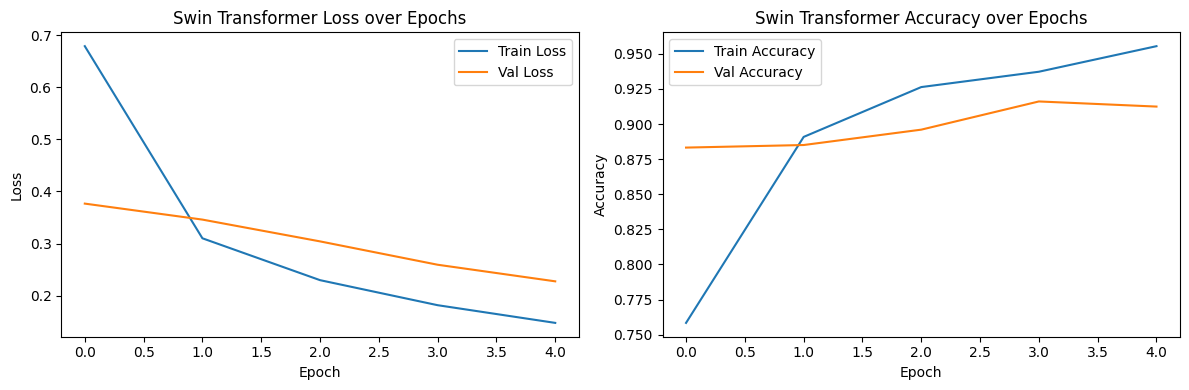

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

NUM_CLASSES = 5  # 실제 클래스 수에 맞게 수정
EPOCHS = 5      # 예시로 10으로 설정 (적절히 조정)
LEARNING_RATE = 1e-3

SWIN_MODEL_URL = "https://tfhub.dev/sayakpaul/swin_tiny_patch4_window7_224/1"

inputs = Input(shape=(224, 224, 3))

swin_layer = hub.KerasLayer(
    SWIN_MODEL_URL,
    trainable=False,
    output_shape=[1000]
)

features = Lambda(lambda x: swin_layer(x),
                  output_shape=lambda input_shape: (input_shape[0], 1000))(inputs)
x = Dense(256, activation='relu')(features)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_swin = Model(inputs=inputs, outputs=outputs)

model_swin.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_swin.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,              # val_loss가 3 epoch 연속 개선되지 않으면 중단
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,              # 학습률을 1/5로 감소
    patience=2,              # 2 epoch 동안 개선 없으면 감소
    min_lr=1e-6
)

history_swin = model_swin.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

loss_swin, accuracy_swin = model_swin.evaluate(validation_generator)
print(f"Swin Validation Loss: {loss_swin:.4f}")
print(f"Swin Validation Accuracy: {accuracy_swin:.4f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_swin.history['loss'], label='Train Loss')
plt.plot(history_swin.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Swin Transformer Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_swin.history['accuracy'], label='Train Accuracy')
plt.plot(history_swin.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Swin Transformer Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


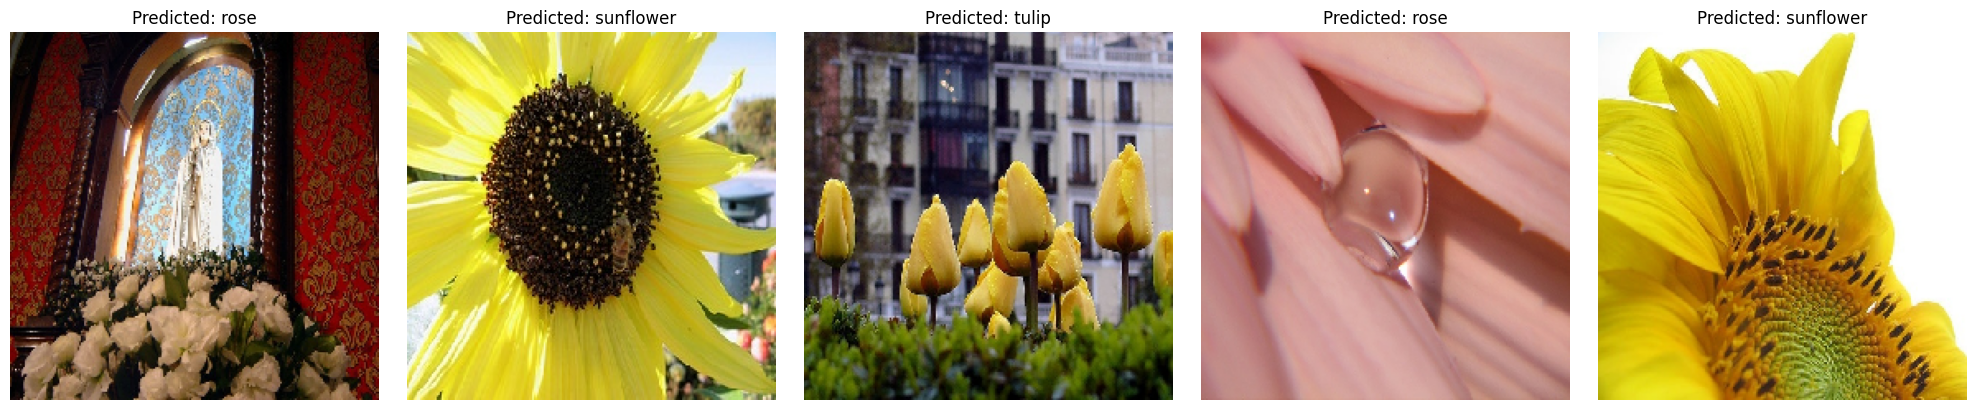

In [ ]:
import random

test_files = [f for f in os.listdir(TEST_DIR)]
selected_files = random.sample(test_files, 5)

plt.figure(figsize=(20, 4))

for i, file in enumerate(selected_files):
    image_path = os.path.join(TEST_DIR, file)
    # 이미지 로드 및 전처리
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # 스케일링
    # 배치 차원 추가
    img_batch = np.expand_dims(img_array, axis=0)

    # 모델 예측 (모델은 이미 학습된 상태여야 함)
    pred = model.predict(img_batch)
    pred_index = np.argmax(pred, axis=1)[0]
    pred_label = classes[pred_index]

    # 이미지 시각화
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()